## 1. Фича для анализа

Понижение коэффициента surge, чтобы увеличить price-to-order конверсию (во время surge) \
Ожидаем: выше price-to-order конверсия во время surge

## 2. Отбор нужного сегмента

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.stats import ttest_ind

In [3]:
df = pd.read_csv('post_abtest_data.csv')
df_surge = df[df['surge']=='surge']
# df_surge['conv_p2o'] = df_surge['order_made']/df_surge['price_seen']
df_surge

,user_id,date,app_opened,group,price_seen,order_made,surge,os,user_cancelled,city_center_order,groups
1,867689,2020-05-29,1,Control,1,0,surge,iOS,NaN,NaN,Control
2,867689,2020-05-25,1,Control,1,1,surge,Android,0.0,0.0,Control
3,752172,2020-05-29,1,Control,1,1,surge,Android,0.0,1.0,Control
5,486559,2020-05-25,1,Control,1,0,surge,Android,NaN,NaN,Control
8,486559,2020-05-28,1,Control,1,0,surge,iOS,NaN,NaN,Control
...,...,...,...,...,...,...,...,...,...,...,...
101484,380230,2020-05-26,1,Control,1,1,surge,Android,0.0,1.0,Control
101486,946650,2020-05-26,1,Test,1,1,surge,Android,0.0,0.0,Test
101492,811157,2020-05-26,1,Control,1,0,surge,iOS,NaN,NaN,Control
101493,442716,2020-05-26,1,Test,1,1,surge,Android,0.0,1.0,Test


In [4]:
df_surge = df_surge.groupby(['user_id','groups','date']).agg({'order_made':'sum','price_seen':'sum'}).reset_index()
df_surge

,user_id,groups,date,order_made,price_seen
0,100093,Test,2020-05-25,1,1
1,100093,Test,2020-05-30,1,1
2,100134,Test,2020-05-27,1,1
3,100166,Control,2020-05-27,2,2
4,100166,Control,2020-05-31,0,1
...,...,...,...,...,...
26470,999878,Test,2020-05-28,0,1
26471,999878,Test,2020-05-29,1,1
26472,999945,Test,2020-05-25,0,1
26473,999978,Control,2020-05-30,1,1


## 3. Бакетинг и расчет p-value

In [5]:
def bucketing(df_temp, group):
    df_bucket = df_temp[df_temp['groups']==group]
    df_bucket['sample'] = 0
    for i in range(len(df_bucket)):
        df_bucket['sample'].values[i] = random.randint(1,10)

    df_bucket = df_bucket.groupby('sample').agg({'order_made':'mean','price_seen':'mean'}).reset_index()
    df_bucket['metric'] = df_bucket['order_made']/df_bucket['price_seen']
    return df_bucket

In [6]:
p_values = []
for date in sorted(df_surge['date'].unique()):
    df_temp = df_surge[df_surge['date']<=date]
    df_control = bucketing(df_temp, 'Control')
    df_test = bucketing(df_temp, 'Test')
    stat, p = ttest_ind(df_test['metric'], df_control['metric'])
    p_values.append(p)
    print('Дата: ',date)
    print('t-value =', stat)
    print('p-value =', p)

<ipython-input-5-7787d81c4a27>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bucket['sample'] = 0


Дата:  2020-05-25
t-value = 3.6566645011424743
p-value = 0.001804661345294421
Дата:  2020-05-26
t-value = 1.5362625551957396
p-value = 0.14186561348230226
Дата:  2020-05-27
t-value = 2.1959561642367302
p-value = 0.04144108468917482
Дата:  2020-05-28
t-value = 3.357296444346378
p-value = 0.0035078647726526882
Дата:  2020-05-29
t-value = 2.5657185211482347
p-value = 0.01944937600819427
Дата:  2020-05-30
t-value = 2.856004438158925
p-value = 0.010495245717726276
Дата:  2020-05-31
t-value = 3.4037985257558483
p-value = 0.003164771720089624


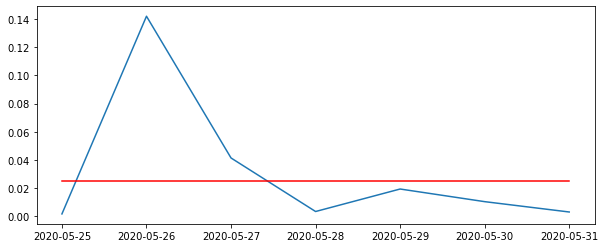

In [7]:
alpha=0.05

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.plot(sorted(df_surge['date'].unique()), p_values)
ax.plot(sorted(df_surge['date'].unique()), [alpha/2]*7, color='red')

Вывод: \
На второй день p-value резко возросло, затем снизилось до значения меньше alpha/2. Необходимо понаблюдать за динамикой еще какое-то время, чтобы быть уверенным в результатах теста.